In [1]:
import stdpopsim
import matplotlib.pyplot as plt
import numpy as np
import tskit

/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [27]:
species = stdpopsim.get_species("HomSap")
contig = species.get_contig("chr22")
model = species.get_demographic_model("OutOfAfrica_2T12")
samples = model.get_samples(1000, 1000)
engine = stdpopsim.get_default_engine()
ts = engine.simulate(model, contig, samples)
print(
    "simulated {} trees and {} sites, from {} samples.".format(
        ts.num_trees, ts.num_sites, ts.num_samples
    )
)

/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/models.py:248: DeprecatedFeatureWarning: The use of `DemographicModel.get_samples` (Python API) and positional sample counts (CLI) is deprecated. Instead, supply a {population_name:num_samples} dict to `Engine.simulate(samples=...)` (Python API); or use the syntax `stdpopsim SpeciesName population_name:num_samples` (CLI).
  warnings.warn(
/nfs_home/users/osvk/.conda/envs/msprime-tskit-env/lib/python3.11/site-packages/stdpopsim/engines.py:120: UserWarning: The demographic model has mutation rate 2.36e-08, but this simulation used the contig's mutation rate 1.29e-08. Diversity levels may be different than expected for this species. For details see documentation at https://popsim-consortium.github.io/stdpopsim-docs/stable/tutorial.html
  warnings.warn(


simulated 744042 trees and 472919 sites, from 2000 samples.


In [28]:
# my_ts.dump("ts_OutOfAfrica_2T12_80k.trees")

In [29]:
YRI_samples = ts.samples(0)
EUR_samples = ts.samples(1)
ts_YRI = ts.simplify(samples=YRI_samples)
ts_EUR = ts.simplify(samples=EUR_samples)

In [30]:
ts_EUR

In [31]:
def get_single_mutation_sites(ts):
    sites_with_one_mut = np.where(
        np.bincount(ts.mutations_site, minlength=ts.num_sites) == 1
    )[0]
    return sites_with_one_mut

In [34]:
import time


def compute_ld_with_time(sites_a, sites_b, ts):
    ldcalc = tskit.LdCalculator(ts)
    r2 = []
    compute_times = []
    for a, b in zip(sites_a, sites_b):
        start = time.perf_counter()
        r2.append(ldcalc.r2(a, b))
        compute_times.append(time.perf_counter() - start)
    return r2, compute_times


def compute_distance_between_sites(sites_a, sites_b, ts):
    distances = []
    for a, b in zip(sites_a, sites_b):
        distances.append(abs(ts.sites_position[a] - ts.sites_position[b]))
    return distances


def return_random_sites_in_range(sites_a, ts, max_dist=200_000):
    sites_with_one_mut = get_single_mutation_sites(ts)
    sites_pos_with_one_mut = np.take(ts.sites_position, sites_with_one_mut)
    sites_b = []
    for a in sites_a:
        a_pos = ts.sites_position[a]
        ld_range = np.where(
            (sites_pos_with_one_mut >= a_pos - max_dist)
            & (sites_pos_with_one_mut <= a_pos + max_dist)
        )[0]
        rand_ind = np.random.choice(ld_range)
        sites_b.append(sites_with_one_mut[rand_ind])
    return sites_b

In [35]:
# use the above methods to compute r2 and compute times for the YRI and EUR populations
# for 100 randomly chosen sites that are within 200kb of each other
num_sites = 500
max_dist = 200_000
YRI_sites_a = np.sort(
    np.random.choice(get_single_mutation_sites(ts_YRI), size=num_sites)
)
YRI_sites_b = return_random_sites_in_range(YRI_sites_a, ts_YRI, max_dist=max_dist)
YRI_r2, YRI_compute_times = compute_ld_with_time(YRI_sites_a, YRI_sites_b, ts_YRI)
YRI_distances = compute_distance_between_sites(YRI_sites_a, YRI_sites_b, ts_YRI)
YRI_distances = np.array(YRI_distances) / 1_000

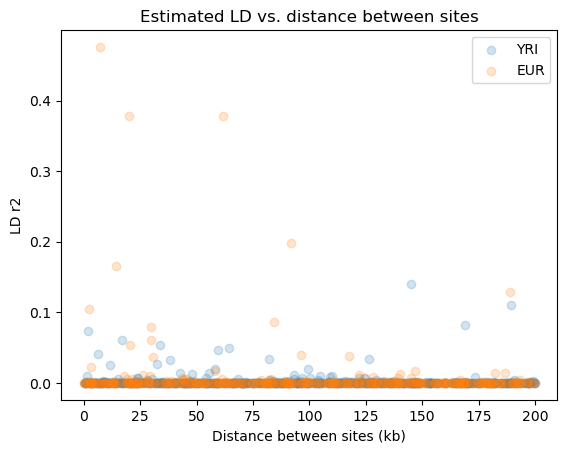

In [37]:
# use the above methods to compute r2 and compute times for the EUR population
# for 100 randomly chosen sites that are within 200kb of each other
EUR_sites_a = np.sort(
    np.random.choice(get_single_mutation_sites(ts_EUR), size=num_sites)
)
EUR_sites_b = return_random_sites_in_range(EUR_sites_a, ts_EUR, max_dist=max_dist)
EUR_r2, EUR_compute_times = compute_ld_with_time(EUR_sites_a, EUR_sites_b, ts_EUR)
EUR_distances = compute_distance_between_sites(EUR_sites_a, EUR_sites_b, ts_EUR)
EUR_distances = np.array(EUR_distances) / 1_000
# plot the results
plt.scatter(YRI_distances, YRI_r2, alpha=0.2, label="YRI")
plt.scatter(EUR_distances, EUR_r2, alpha=0.2, label="EUR")
plt.xlabel("Distance between sites (kb)")
plt.ylabel("LD r2")
plt.title("Estimated LD vs. distance between sites")
plt.legend()
plt.show()

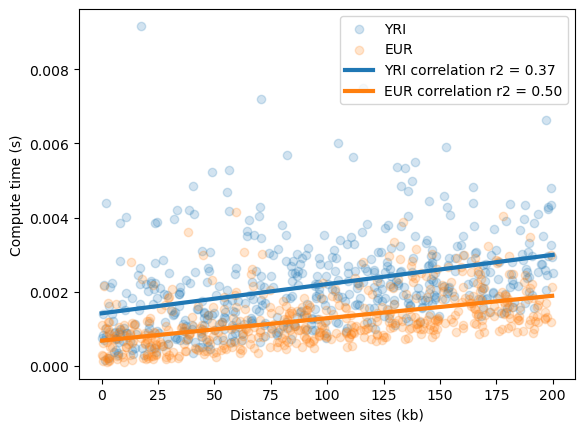

In [39]:
# compare the compute times v distance for the two populations as a grouped scatter plot
plt.scatter(YRI_distances, YRI_compute_times, alpha=0.2, label="YRI")
plt.scatter(EUR_distances, EUR_compute_times, alpha=0.2, label="EUR")
corr_YRI = (
    f"YRI correlation r2 = {np.corrcoef(YRI_distances, YRI_compute_times)[0,1]:.2f}"
)
corr_EUR = (
    f"EUR correlation r2 = {np.corrcoef(EUR_distances, EUR_compute_times)[0,1]:.2f}"
)
# plt.text(0.4, 0.6, f"EUR correlation r2 = {np.corrcoef(EUR_distances, EUR_compute_times)[0,1]:.2f}")
plt.plot(
    np.unique(YRI_distances),
    np.poly1d(np.polyfit(YRI_distances, YRI_compute_times, 1))(
        np.unique(YRI_distances)
    ),
    label=f"{corr_YRI}",
    linewidth=3,
)
plt.plot(
    np.unique(EUR_distances),
    np.poly1d(np.polyfit(EUR_distances, EUR_compute_times, 1))(
        np.unique(EUR_distances)
    ),
    label=f"{corr_EUR}",
    linewidth=3,
)
plt.xlabel("Distance between sites (kb)")
plt.ylabel("Compute time (s)")
plt.legend()
plt.show()

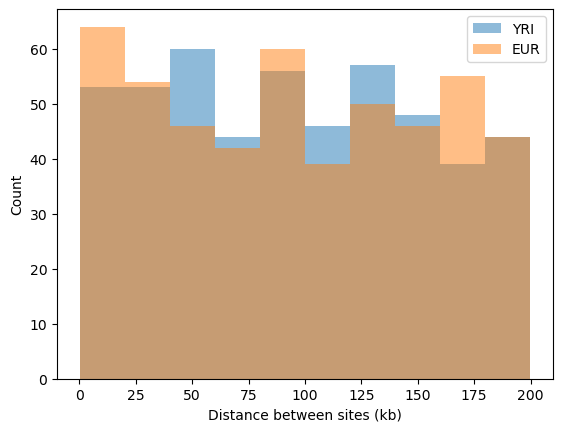

In [40]:
plt.hist(YRI_distances, alpha=0.5, label="YRI")
plt.hist(EUR_distances, alpha=0.5, label="EUR")
plt.xlabel("Distance between sites (kb)")
plt.ylabel("Count")
plt.legend()
plt.show()

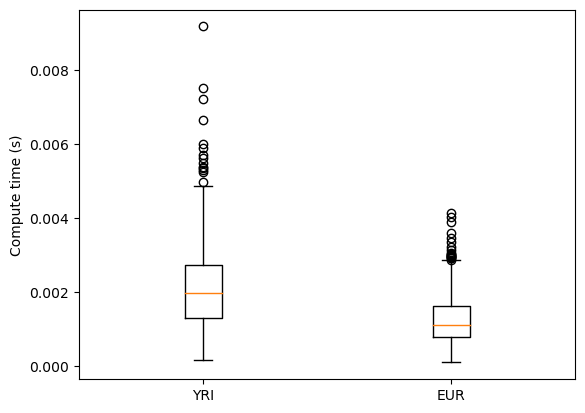

In [41]:
# plot the compute times for the two populations as a grouped boxplot
plt.boxplot([YRI_compute_times, EUR_compute_times], labels=["YRI", "EUR"])
plt.ylabel("Compute time (s)")
plt.show()